## Note to Hava

This notebook is moderately sophisticated, and any exercise based on this kind of material would necessarily come <i>after</i> earlier exerccises.  Here's the kind of exercises that I can imagine that might come first.

+ Exercise to get everybody up to approximately same level with python/jupyter.  Basically whatever it takes to get students ready to do the next exercise.
+ <b>Numerical Integration I</b>. Have small groups discuss a simple strategy for numerically evaluation of 
the definite integral of a simple function; no coding yet, just ideas and pseudo-code. (I don't think this should
need much introduction from an instructor.) Then have individual students
write code that implements that strategy.  (If this is an easy task for some students, have questions ready 
that probe how well their strategy works (What's the error? What would you have to do to decrease the 
error?)
+ <b>Numerical Integration II</b>. (Maybe part of Numerical Integration I)  Provide functions that are 
problematic in some way.  This might be functions with widely varying scales for the independent variable; or functions with singularities; or other difficulties).  Basically, my goal would be to give students an 
appreciation for why the simplest of approaches, while conceptually correct, and easy to understand, might not suffice for real-world problems.
+ <b>Numerical Integration III</b>. Smart people have been come up with  ways to "automatically" handle 
integration of some kinds of problematic functions. One set of tools (out of many) that take advantage
of the work of these smart people is found in the <code>python</code>/<code>numpy</code>/<code> scipy</code> computing "ecosystem."  My goal for this 
exercise would be to get students up to speed to using something like <code>scipy.integrate.quad</code> (there 
are, of course, other good tools), and
perhaps show how to use it to evaluate definite integrals that could be done with code written by 
students, but also show how to use it in an example (or examples) that show that things like adaptive
step size are a big improvement on the simplest numerical integration schemes.
+ <b>Numerical Integration IV (and V?)</b>. Numerical integration of Coulomb's law for 
static charge distributions.
+ <b>Numerical Integration V (and VI?) -- Vector operations and computation.</b> Introduce examples that take advantage of vector operations inherent
in <code>numpy</code> and numerical differentiation of vectors that are provided in the <code>numdifftools</code>
module . (See my intro to <code>numdifftools</code> module at http://www.eg.bucknell.edu/~phys310/jupyter/numdiff.html )
+ <b>Integration of Biot-Savart law.</b> Subject of this notebook

## Biot-Savart with numerical differentiation, integration, and evaluation

This notebook is Inspired by Mr. P Solver's YouTube video "Biot Savart Law in Python: Any wire you want, no paper required."
In that video the numerical evaluation of the integrand is facilitated with a detour to SymPy to handle 
the vectors and perform differentiation.  A call to <code>lambdify()</code> returns a function suitable for numerical evaluation.  This notebook demonstrates a way to avoid the SymPy detour, using <code>numpy</code>'s built-in capabilities to do vector algebra.
The notebook also uses the 
<code>numdifftools</code> package to perform numerical differentiation of the path ${\bf l}(t)$. For examples of numerical calculation of the derivatives, curl, divergence, and laplacian operators, see http://www.eg.bucknell.edu/~phys310/jupyter/numdiff.html, 
http://www.eg.bucknell.edu/~phys310/jupyter/numdiff.ipynb.

### Biot-Savart law:

$$
{\bf B}({\bf r}) = \frac{\mu_0}{4\pi}\, I \int\frac{d{\bf l}^\prime \times {\bf s}}{s^3} 
$$

where ${\bf s}$ is Griffiths script-r vector from source point $d{\bf l}^\prime$ to the 
observation point ${\bf r}$.

The vector path ${\bf l}^\prime$ is parametrized in terms of a scalar $t$:

$$
{\bf l}^\prime(t) = l^\prime_x(t)\, \hat{{\bf x}}+ l^\prime_y(t)\, \hat{{\bf y}}+ l^\prime_z(t)\, \hat{{\bf z}},
$$

so that

$$ 
d{\bf l}^\prime = \left(\frac{dl^\prime_x}{dt}\, \hat{{\bf x}}
+ \frac{dl^\prime_y}{dt}\, \hat{{\bf y}} + 
\frac{dl^\prime_z}{dt}\, \hat{{\bf z}}\right) dt
$$

It is convenient to work with dimensionless parameters defined in terms of some characteristic length
$R$ characterizing the source:

$$
{\bf r}_{\rm nd} \equiv \frac{\bf r}{R} \quad\quad {\bf l}_{\rm nd} \equiv \frac{\bf l}{R}\quad\quad 
{\bf s}_{\rm nd} \equiv \frac{\bf s}{R}\quad\quad\mbox{and}
\quad\quad{\bf B}_{\rm nd} \equiv \frac{{\bf B}_{\rm nd}}{\mu_0 I/(4\pi R)}.
$$

The Biot-Savart law written in terms of these parameters is 

$$
{\bf B}_{\rm nd} = \int\frac{d{\bf l}^\prime_{\rm nd} \times {\bf s}_{\rm nd}}{(s_{\rm nd})^3}
$$

In the numerical work that follows it is implicit that all quantities are nondimensional, and no "nd" subscripts
will be used.

The dimensional magnetic field can be recovered by multiplying the numerical results below by the factor $\mu_0I/(4\pi R)$.


Marty Ligare, October 2022

In [1]:
import numpy as np
import numdifftools as nd  # See https://pypi.python.org/pypi/Numdifftools
from scipy import integrate

import matplotlib as mpl  
import matplotlib.pyplot as plt

In [2]:
# Following is an Ipython magic command that puts figures in the  notebook.
# For figures in separate windows, comment out following line and uncomment
# the next line
# Must come before defaults are changed.
%matplotlib notebook
#%matplotlib

# As of Aug. 2017 reverting to 1.x defaults.
# In 2.x text.ustex requires dvipng, texlive-latex-extra, and texlive-fonts-recommended, 
# which don't seem to be universal
# See https://stackoverflow.com/questions/38906356/error-running-matplotlib-in-latex-type1cm?
mpl.style.use('classic')
        
# M.L. modifications of matplotlib defaults using syntax of v.2.0 
# More info at http://matplotlib.org/2.0.0/users/deflt_style_changes.html
# Changes can also be put in matplotlibrc file, or effected using mpl.rcParams[]
plt.rc('figure', figsize = (6, 4.5))            # Reduces overall size of figures
plt.rc('axes', labelsize=16, titlesize=14)
plt.rc('figure', autolayout = True)             # Adjusts supblot parameters for new size

### The following three functions for the components of the ${\bf l}$-vector must be determined by analysis of the source.

 They are set initially for a circular loop of current in the $x$-$y$ plane, with $0\leq t \leq 1$. $R$ is 
 set to the radius of the loop, so that $R^\prime$ (the radius used in the numerical calculations) is 1.

In [3]:
def lx(t):
    '''x-component of vector dl'''
    return np.cos(2.*np.pi*t)

def ly(t):
    '''y-component of vector dl'''
    return np.sin(2.*np.pi*t)

def lz(t):
    '''z-component of vector dl'''
    return 0

### The following functions are source-independent

In [4]:
dlx = nd.Derivative(lx)
dly = nd.Derivative(ly)
dlz = nd.Derivative(lz)

In [5]:
def integrand_x(t, x, y, z):
    '''Vector integrand in Biot-Savart law.  Uses numpy to evaluate cross-product numerically'''
    sx = x - lx(t)
    sy = y - ly(t)
    sz = z - lz(t)
    s = np.array([sx,sy,sz])
    dl = np.array([dlx(t),dly(t),dlz(t)])
    return (np.cross(dl,s)/np.dot(s,s)**(3/2))[0]

def integrand_y(t, x, y, z):
    '''Vector integrand in Biot-Savart law.  Uses numpy to evaluate cross-product numerically'''
    sx = x - lx(t)
    sy = y - ly(t)
    sz = z - lz(t)
    s = np.array([sx,sy,sz])
    dl = np.array([dlx(t),dly(t),dlz(t)])
    return (np.cross(dl,s)/np.dot(s,s)**(3/2))[1]

def integrand_z(t, x, y, z):
    '''Vector integrand in Biot-Savart law.  Uses numpy to evaluate cross-product numerically'''
    sx = x - lx(t)
    sy = y - ly(t)
    sz = z - lz(t)
    s = np.array([sx,sy,sz])
    dl = np.array([dlx(t),dly(t),dlz(t)])
    return (np.cross(dl,s)/np.dot(s,s)**(3/2))[2]


def Bx(x,y,z):
    '''Perform integration of x-component'''
    a = integrate.quad(integrand_x, 0., 1., args=(x,y,z,))
    return a[0]

def By(x,y,z):
    '''Perform integration of y-component'''
    a = integrate.quad(integrand_y, 0., 1., args=(x,y,z,))
    return a[0]

def Bz(x,y,z):
    '''Perform integration of z-component'''
    a = integrate.quad(integrand_z, 0., 1., args=(x,y,z,))[0]
    return a

def B(x,y,z):
    '''Perform integration of each component and return all components'''
    Bx = integrate.quad(integrand_x, 0, 1, args=(x,y,z))[0]
    By = integrate.quad(integrand_y, 0, 1, args=(x,y,z))[0]
    Bz = integrate.quad(integrand_z, 0, 1, args=(x,y,z))[0]
    
    return np.array([Bx, By, Bz])
    #return Bx, By, Bz

### Simple testing: field at center of loop

#### Dimensionless field

In [6]:
Bx(0,0,0), By(0,0,0), Bz(0,0,0)

(0.0, 0.0, 6.2831853071796475)

OR

In [7]:
B(0,0,0)

array([0.        , 0.        , 6.28318531])

#### Dimensional field:

\begin{eqnarray*}
{\bf B}(0,0,0) &=& \frac{\mu_0 I}{4\pi R} \times (\mbox{dimensionless result from cell above}) \\
               &=& \frac{\mu_0 I}{4\pi R} \times (2\pi\,  \hat{\bf z}) \\
               &=& \frac{\mu_0 I}{2 R} \hat{\bf z}
\end{eqnarray*}

This is the correct result (see, e.g., Griffiths).

### Simple testing: field above center of loop:  ${\bf r} = 2R\, \hat{{\bf z}}$ 

#### Dimensionless field

In [8]:
Bx(0,0,2), By(0,0,2), Bz(0,0,2)

(1.1352030426792226e-14, -9.237238606819288e-15, 0.5619851784832635)

#### Dimensional field:

\begin{eqnarray*}
{\bf B}(0,0,0) &=& \frac{\mu_0 I}{4\pi R} \times (\mbox{dimensionless result from cell above}) \\
               &=& \frac{\mu_0 I}{4\pi R} \times (0.562\,  \hat{\bf z}) \\
               &\simeq& \frac{\mu_0 I}{2 R}\, 0.09844\,\hat{\bf z}
\end{eqnarray*}

The analytical result (see, e.g., Griffiths), is

\begin{eqnarray*}
{\bf B}(0,0,2R) &=& \frac{\mu_0 I}{2} \frac{R^2}{[R^2 + (2R^2)^{3/2}]} \\
                &\simeq& \frac{\mu_0 I}{2R}\, 0.09844\,\hat{\bf z}
\end{eqnarray*}

### How does field behave along a radial line out from center of loop?

In [9]:
x = np.linspace(0,0.9, 10)
y = np.empty(10)
for i in range(len(x)):
    y[i] = Bz(x[i],0,0)

#### Alternative calculation to that above that eliminates explicit loop

In [10]:
vec_Bz = np.vectorize(Bz)
y2 = vec_Bz(x,0,0)

<IPython.core.display.Javascript object>


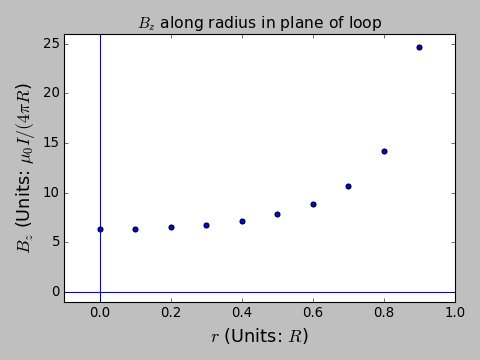

In [11]:
plt.figure()
plt.axhline(0)
plt.axvline(0)
plt.xlim(-0.1,1)
plt.ylim(-1,26)
plt.title("$B_z$ along radius in plane of loop")
plt.xlabel("$r$ (Units: $R$)")
plt.ylabel("$B_z$ (Units: $\mu_0 I/(4\pi R$)")
plt.scatter(x,y2);

### Creating a meshgrid of points for visualiztion of vector field

There is a complication in creating a `meshgrid` of values of the components of the electric field. 
For example, using normal syntax, like 

`U, W = Bx(X,0,Z), Bz(X,0,Z)`

won't work here.  The problem is in the passing `array`s of values in the `args` of  `np.quad`.

The first work-around is the "brute force" creation of `meshgrids` for `U` and `W`, 
and filling them with explicit loops.

The second work-around is the use of `np.vectorize()` to make `numpy` do the looping automatically.
From the documentation: "The `vectorize` function is provided primarily for convenience, not for performance. The implementation is essentially a `for` loop," i.e., it isn't truly broadcasting over the arrays -- but it works.
(See below).

#### Brute force looping to fill meshgrid for valuues of $x$- and $y$-components of magnetic  field

In [12]:
x = np.array([-2,0,2])
z = np.array([-2,-1,0,1,2])
X, Z = np.meshgrid(x,z)

U = np.zeros(np.shape(X))
W = np.zeros(np.shape(X))

for i in range(len(z)):
    for k in range(len(x)):
        U[i,k] = Bx(X[i,k], 0, Z[i,k])
        W[i,k] = Bz(X[i,k], 0, Z[i,k])
        #print(i, k, X[i,k], Z[i,k], U[i,k], W[i,k])

<IPython.core.display.Javascript object>


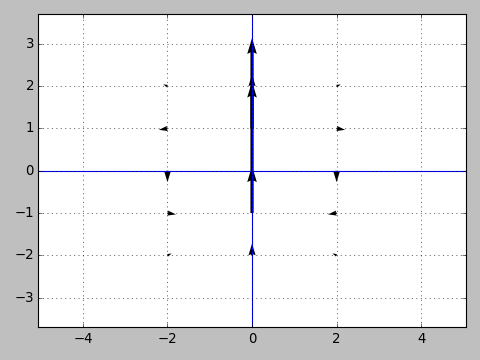

In [13]:
plt.figure()
plt.quiver(X, Z, U, W, scale=2, scale_units='xy')
plt.axis('equal')
plt.axhline(0)
plt.axvline(0)
plt.ylim(-4,4)
plt.grid();

#### Alternative to brute force looping to fill meshgrid for valuues of $x$- and $y$-components of electric field
Uses `np.vectorize()` to make `numpy` do the looping automatically for inputs to `args` of the `np.quad` 
integration.
From the documentation: "The `vectorize` function is provided primarily for convenience, not for performance. The implementation is essentially a `for` loop."

In [14]:
vec_Bx = np.vectorize(Bx)
vec_Bz = np.vectorize(Bz)
U, W = vec_Bx(X,0,Z), vec_Bz(X,0,Z)

<IPython.core.display.Javascript object>


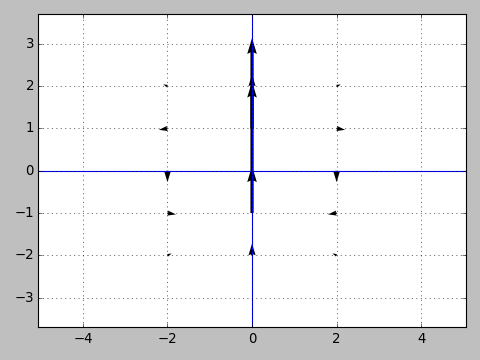

In [15]:
plt.figure()
plt.quiver(X, Z, U, W, scale=2, scale_units='xy')
plt.axis('equal')
plt.axhline(0)
plt.axvline(0)
plt.ylim(-4,4)
plt.grid();

### Version Information 
`version_information` is from J.R. Johansson (jrjohansson at gmail.com)<br>
See Introduction to scientific computing with Python:<br>
http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb <br>
for more information and instructions for package installation.<br>

If `version_information` has been installed system wide (as it has been on Bucknell linux computers with shared file systems), continue with next cell as written.  If not, comment out top line in next cell and uncomment the second line.

In [16]:
%load_ext version_information

#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

In [17]:
version_information numpy, scipy, matplotlib, numdifftools

Software versions
Python 3.7.13 64bit [GCC 7.5.0]
IPython 7.31.1
OS Linux 4.9.0 9 amd64 x86_64 with debian 9.13
numpy 1.21.5
scipy 1.7.3
matplotlib 3.5.2
numdifftools 0.9.39
Mon Nov 14 12:55:46 2022 EST